# Groundtruth training on focused edges (training 1)

In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

## Presentation

For each different training we proceed as follow:

Step 1: random search or bayesian search over a lot of models and parameters\
Step 2: evaluate the 3 best models with cross validation and chose the best out of the 3

For the seed, we always take the same seed: 100

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import imageio

from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import keras_tuner as kt

from amftrack.ml.width.models import hyper_model_builder_simple, build_model_dense, build_model_conv
from amftrack.util.sys import storage_path
from amftrack.ml.width.data_augmentation import data_augmentation

/home/felix/Wks/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2022-08-16 16:13:10.890354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/cv2/../../lib64::/opt/gurobi951/linux64/lib
2022-08-16 16:13:10.890438: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-16 16:13:10.890492: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (felix-XPS-13-9360): /proc/driver/nvidia/version does not exist
2022-08-16 16:13:10.891963: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlo

### Fetch data

Repository with all possible datasets

In [ ]:
dataset_path = os.path.join(storage_path, "datasets")

Two datasets that I have choosen to use

In [3]:
focused_dataset_path = os.path.join(dataset_path, "focused_with_varying_lum_train") # dataset with varying lumination but consistent focus
extended_dataset_path = os.path.join(dataset_path, "varying_lum_and_focus_train") # dataset with varying lumination but consistent focus

For now: using the focused dataset

In [10]:
path = focused_dataset_path

In [11]:
im_path = os.path.join(path, "slices.png")
label_path = os.path.join(path, "labels.npy")

In [12]:
im = imageio.imread(im_path)
print(im.shape)

(527, 120)


In [13]:
with open(label_path, 'rb') as f:
    label = np.load(f)
print(label.shape)

(527,)


In [14]:
label = np.expand_dims(label, axis = 1)

In [15]:
label.shape

(527, 1)

### Data preparation

For seperating the test set (not used for now as the test is done in another notebook²)

In [331]:
seed = 11
np.random.seed(11)
p = np.random.permutation(len(label))
training = p[:-150]
valid = p[-150:]
print(len(training))
print(len(valid))

377
150


In [332]:
train_feature = im[training, :]
train_label = label[training,0]
valid_feature = im[valid, :]
valid_label = label[valid, :]

Instead we just take it all

In [262]:
train_feature.shape

(527, 120)

### Visualisation

In [84]:
i = 300

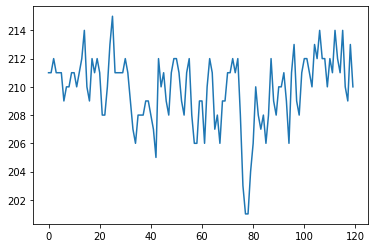

In [85]:
plt.plot(im[i,:])

In [86]:
label[i,:]

array([3.54463004])

## Mean predicting model

In [108]:
train_label.shape

(527, 1)

In [115]:
np.var(train_label)

5.0398003951031365

In [116]:
np.std(train_label)

2.2449499760803437

In [124]:
mean = np.mean(train_label)
pred = np.full(train_label.shape, mean)
res = np.mean((train_label - pred)**2)
print(f"Mean is: {mean}, Mean squarred error is: {res}")

Mean is: 5.1677101321532035, Mean squarred error is: 5.0398003951031365


In [123]:
mean = np.mean(train_label)
pred = np.full(train_label.shape, mean)
res = np.mean(abs(train_label - pred))
print(f"Mean is: {mean}, Mean absolute error is: {res}")

Mean is: 5.1677101321532035, Mean absolute error is: 1.5734396720993393


## Data preprocessing

### Train dataset

In [309]:
from amftrack.ml.width.data_augmentation import data_preparation, data_augmentation, random_crop, random_mirror, random_invert, random_brightness

In [310]:
train_feature.shape

(527, 120)

PROPRE

In [311]:
train_feature_ds = np.expand_dims(train_feature, axis = -1)
train_feature_ds = np.expand_dims(train_feature_, axis = -3)

In [312]:
train_feature_ds.shape

(527, 1, 120, 1)

In [313]:
d1 = tf.data.Dataset.from_tensor_slices(train_feature_ds)
d2 = tf.data.Dataset.from_tensor_slices(train_label)
train_ds = tf.data.Dataset.zip((d1, d2))

In [317]:
train_ds = (
    train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    .unbatch()
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

TEST

In [318]:
for e in train:
    break

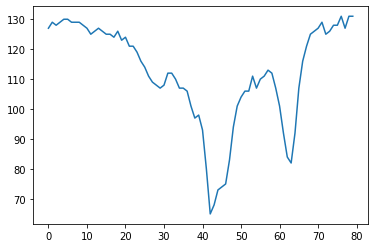

In [308]:
plt.plot(np.array(e[0][0,:,0]))

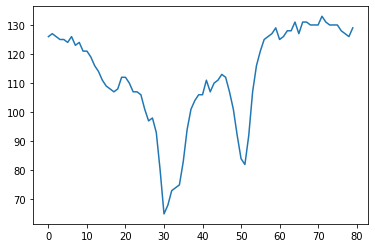

In [319]:
plt.plot(np.array(e[0][0,:,0]))

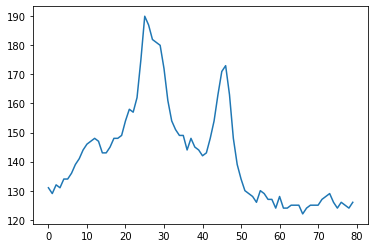

In [299]:
plt.plot(np.array(e[0][0,:,0]))

### Test dataset

In [339]:
valid_feature_ds = np.expand_dims(valid_feature, axis = -1)
valid_feature_ds = np.expand_dims(valid_feature_ds, axis = -3)
d1 = tf.data.Dataset.from_tensor_slices(valid_feature_ds)
d2 = tf.data.Dataset.from_tensor_slices(valid_label)
valid_ds = tf.data.Dataset.zip((d1, d2))
valid_ds = (
    valid_ds.map(lambda x, y: (data_preparation(x, training=True), y))
    .unbatch()
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

In [342]:
for e in valid_ds:
    print(e)
    break

(<tf.Tensor: shape=(32, 80, 1), dtype=float32, numpy=
array([[[138.],
        [136.],
        [136.],
        ...,
        [134.],
        [136.],
        [134.]],

       [[188.],
        [189.],
        [187.],
        ...,
        [181.],
        [181.],
        [178.]],

       [[165.],
        [163.],
        [165.],
        ...,
        [165.],
        [166.],
        [165.]],

       ...,

       [[146.],
        [146.],
        [145.],
        ...,
        [144.],
        [146.],
        [152.]],

       [[148.],
        [145.],
        [141.],
        ...,
        [206.],
        [207.],
        [202.]],

       [[204.],
        [204.],
        [203.],
        ...,
        [207.],
        [205.],
        [205.]]], dtype=float32)>, <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([5.24173503, 4.34090199, 3.71157107, 8.97995119, 5.29939395,
       5.29939395, 5.4984222 , 2.85702873, 5.35827466, 4.18356936,
       4.34090199, 3.06895321, 4.45399496, 4.67930649, 4.88385177,
  

## Training a dense model

### 1/ Run hyperparameter search

In [324]:
tuner = kt.RandomSearch(
    build_model_dense,
    objective='val_mean_absolute_error',
    max_trials=100,
    seed=seed,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True
)

Without augmentation:

Actual search

In [327]:
tuner.search(train_ds,
             validation_data= valid_ds,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)])

Trial 100 Complete [00h 00m 02s]
val_mean_absolute_error: 2.411165237426758

Best val_mean_absolute_error So Far: 0.9832203388214111
Total elapsed time: 00h 06m 23s
INFO:tensorflow:Oracle triggered exit
2022-08-16 18:48:22,165-[INFO]- tensorflow:1 -> Oracle triggered exit


### 2/ Analyse hyperparameter search results

#### Search space

In [30]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
input_size (Fixed)
{'conditions': [], 'value': 80}
hidden_size (Int)
{'default': 32, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 32, 'sampling': None}
regul (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
dense_blocks (Int)
{'default': 3, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


#### Best model

In [29]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 74
regul: 0.0014215854798312684
dense_blocks: 4
dropout: 0.0
learning_rate: 0.0009024056738718249
Score: 0.658259391784668
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 74
regul: 2.2980497006447554e-05
dense_blocks: 10
dropout: 0.0
learning_rate: 0.002103917275801273
Score: 0.7131851315498352
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 42
regul: 0.0035557261842639634
dense_blocks: 3
dropout: 0.0
learning_rate: 0.0016003804865801434
Score: 0.7195175886154175
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 10
regul: 0.00023822269216557592
dense_blocks: 1
dropout: 0.0
learning_rate: 0.011363871072843399
Score: 0.7515721917152405
Trial summary
Hyperparameters:
input_size: 80
hidden_size: 74
regul: 0.00021301425578360573
dense_blocks: 2
dropout: 0.4
learning_rate: 0.0008633835677522632
Score: 0.771540105342865
Trial summary
Hy

In [ ]:
best_models = tuner.get_best_models(5)

In [344]:
best_model = best_models[0]

2022-08-17 09:41:16,265-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-08-17 09:41:16,267-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-08-17 09:41:16,270-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-08-17 09:41:16,277-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-08-17 09:41:16,278-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-08-17 09:41:16,285-[WARNI

In [345]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [346]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 reshape (Reshape)           (None, 80)                0         
                                                                 
 rescaling (Rescaling)       (None, 80)                0         
                                                                 
 dense (Dense)               (None, 74)                5994      
                                                                 
 dropout (Dropout)           (None, 74)                0         
                                                                 
 dense_1 (Dense)             (None, 74)                5550      
                                                                 
 dropout_1 (Dropout)         (None, 74)                0     

#### Visualize prediction on the validation set

In [347]:
def plot_against(model, test_feature, test_label):
    predicted = model.predict(test_feature)
    plt.scatter(test_label, predicted, marker='o')
    plt.plot([0,12],[0,12])
    plt.xlim(2, 16)
    plt.ylim(2, 16)

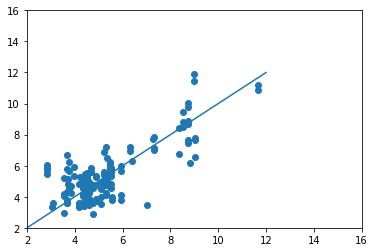

In [348]:
plot_against(best_model, data_preparation(valid_feature), valid_label)

In [361]:
best_model.evaluate(data_preparation(valid_feature), valid_label)

5/5 [==============================] - 0s 2ms/step - loss: 2.0744 - mean_absolute_error: 1.0524


[2.0743775367736816, 1.0523762702941895]

In [354]:
valid_feature.shape

(150, 120)

### 3/ Retrain the best models with cross validation

In [ ]:
from sklearn.model_selection import KFold

In [108]:
def generalisation_estimator(n_split=4):
    evaluations = []
    history = []
    
    for train, valid in KFold(n_split).split(training):
        train, valid_e = next(KFold(4).split(train))
        train_feature = im[train, :]
        train_label = label[train,0]
        valid_e_feature = im[valid_e, :]
        valid_e_label = label[valid_e,0]
        valid_feature = im[valid, :]
        valid_label = label[valid, :]

        model = model1()
        model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
        metrics=[tf.keras.metrics.mean_absolute_error])

        history.append(model.fit(
        train_feature,
        train_label,
        batch_size=5,
        epochs=60,
        validation_data = (valid_e_feature, valid_e_label),
        ))
        evaluations.append(model.evaluate(valid_feature, valid_label))
        
    return model, history, evaluations

In [109]:
model, history, evaluations = generalisation_estimator()

Epoch 1/60
17/17 [==============================] - 1s 30ms/step - loss: 17.1238 - mean_absolute_error: 3.2148 - val_loss: 14.3234 - val_mean_absolute_error: 3.2598
Epoch 2/60
17/17 [==============================] - 0s 23ms/step - loss: 6.3989 - mean_absolute_error: 1.8706 - val_loss: 8.7455 - val_mean_absolute_error: 1.8558
Epoch 3/60
17/17 [==============================] - 0s 23ms/step - loss: 4.0710 - mean_absolute_error: 1.3192 - val_loss: 9.3824 - val_mean_absolute_error: 2.5939
Epoch 4/60
17/17 [==============================] - 0s 23ms/step - loss: 4.6508 - mean_absolute_error: 1.6119 - val_loss: 8.6480 - val_mean_absolute_error: 1.6144
Epoch 5/60
17/17 [==============================] - 0s 23ms/step - loss: 7.0369 - mean_absolute_error: 2.0248 - val_loss: 7.5021 - val_mean_absolute_error: 1.8832
Epoch 6/60
17/17 [==============================] - 0s 23ms/step - loss: 4.1425 - mean_absolute_error: 1.4042 - val_loss: 5.8500 - val_mean_absolute_error: 1.7413
Epoch 7/60
17/17 [==

Epoch 51/60
17/17 [==============================] - 0s 23ms/step - loss: 1.0856 - mean_absolute_error: 0.7518 - val_loss: 5.1233 - val_mean_absolute_error: 1.4783
Epoch 52/60
17/17 [==============================] - 0s 23ms/step - loss: 1.1197 - mean_absolute_error: 0.8066 - val_loss: 5.0851 - val_mean_absolute_error: 1.3119
Epoch 53/60
17/17 [==============================] - 0s 23ms/step - loss: 1.2089 - mean_absolute_error: 0.7972 - val_loss: 6.7413 - val_mean_absolute_error: 1.5297
Epoch 54/60
17/17 [==============================] - 0s 23ms/step - loss: 1.4184 - mean_absolute_error: 0.9370 - val_loss: 6.2432 - val_mean_absolute_error: 1.9085
Epoch 55/60
17/17 [==============================] - 0s 23ms/step - loss: 1.1768 - mean_absolute_error: 0.7910 - val_loss: 5.7321 - val_mean_absolute_error: 1.7284
Epoch 56/60
17/17 [==============================] - 0s 23ms/step - loss: 0.9565 - mean_absolute_error: 0.6961 - val_loss: 5.3689 - val_mean_absolute_error: 1.4958
Epoch 57/60
17/1

17/17 [==============================] - 0s 24ms/step - loss: 1.6820 - mean_absolute_error: 0.8745 - val_loss: 4.7452 - val_mean_absolute_error: 1.3097
Epoch 30/60
17/17 [==============================] - 0s 24ms/step - loss: 2.5017 - mean_absolute_error: 1.2052 - val_loss: 6.0111 - val_mean_absolute_error: 1.4704
Epoch 31/60
17/17 [==============================] - 0s 23ms/step - loss: 2.0644 - mean_absolute_error: 1.0622 - val_loss: 7.2723 - val_mean_absolute_error: 2.4042
Epoch 32/60
17/17 [==============================] - 0s 24ms/step - loss: 1.6950 - mean_absolute_error: 0.9677 - val_loss: 5.1561 - val_mean_absolute_error: 1.4655
Epoch 33/60
17/17 [==============================] - 0s 23ms/step - loss: 1.7365 - mean_absolute_error: 1.0092 - val_loss: 4.7674 - val_mean_absolute_error: 1.2952
Epoch 34/60
17/17 [==============================] - 0s 24ms/step - loss: 1.5431 - mean_absolute_error: 0.9328 - val_loss: 4.7539 - val_mean_absolute_error: 1.6838
Epoch 35/60
17/17 [=========

In [118]:
acc = [e[1] for e in evaluations]
mean = np.mean(acc)
std_dev = np.std(acc)
print(f"Mean: {mean} Std: {std_dev}")

Mean: 0.9381397813558578 Std: 0.22633092139606995


In [119]:
history[0].history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

In [120]:
j = 1

## Random search with conv model

### Training

In [23]:
tuner = kt.RandomSearch(
    build_model_conv,
    objective='val_mean_absolute_error',
    max_trials=50,
    seed=seed,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    overwrite=True
)

In [25]:
tuner.search(data_preparation(im),
             label,
             validation_split=0.2,
             epochs=200,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights = True)])

Trial 50 Complete [00h 02m 13s]
val_mean_absolute_error: 0.8619729280471802

Best val_mean_absolute_error So Far: 0.702015221118927
Total elapsed time: 01h 30m 12s
INFO:tensorflow:Oracle triggered exit
2022-08-12 15:44:42,115-[INFO]- tensorflow:1 -> Oracle triggered exit


### Analyse results

In [27]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_size: 80
regul: 0.0002707623734125964
batch_normalization: True
conv_blocks: 3
filters_0: 224
kernel_size0: 19
filters_1: 160
kernel_size1: 20
pooling_1: avg
hidden_size: 10
dense_blocks: 3
dropout: 0.1
learning_rate: 0.020272548846591663
pooling_0: avg
filters_2: 256
kernel_size2: 17
pooling_2: none
Score: 0.702015221118927
Trial summary
Hyperparameters:
input_size: 80
regul: 0.00010991863288278036
batch_normalization: False
conv_blocks: 2
filters_0: 64
kernel_size0: 14
filters_1: 160
kernel_size1: 18
pooling_1: avg
hidden_size: 42
dense_blocks: 3
dropout: 0.5
learning_rate: 0.00638224910178181
pooling_0: max
filters_2: 192
kernel_size2: 15
pooling_2: max
Score: 0.704502284526825
Trial summary
Hyperparameters:
input_size: 80
regul: 0.00032199506051567314
batch_normalization: True
conv_blocks: 2
filters_0: 64
kernel_size0: 13
filters_1: 160
kernel_size1: 5
pooling_1: avg
hidden_siz

In [28]:
best_model = tuner.get_best_models(2)[1]

2022-08-12 15:46:06,331-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-08-12 15:46:06,332-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-08-12 15:46:06,332-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-08-12 15:46:06,333-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-08-12 15:46:06,333-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-08-12 15:46:06,334-[WARNI

In [29]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [30]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 rescaling (Rescaling)       (None, 80, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 71, 64)            704       
                                                                 
 re_lu (ReLU)                (None, 71, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 160)           102560    
                                                                 
 re_lu_1 (ReLU)              (None, 62, 160)           0         
                                                                 
 average_pooling1d (AverageP  (None, 31, 160)          0     

In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 17
input_size (Fixed)
{'conditions': [], 'value': 80}
regul (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
batch_normalization (Boolean)
{'default': False, 'conditions': []}
conv_blocks (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size0 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 1, 'sampling': None}
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_size1 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 20, 'step': 1, 'sampling': None}
pooling_1 (Choice)
{'default': 'avg', 'conditions': [], 'values': ['avg', 'max', 'none'], 'ordered': False}
hidden_size (Int)
{'

In [32]:
def plot_against(model, test_feature, test_label):
    predicted = model.predict(test_feature)
    plt.scatter(test_label, predicted, marker='o')
    plt.plot([0,12],[0,12])
    plt.xlim(2, 16)
    plt.ylim(2, 16)

In [33]:
test_feature

Array([[179, 178, 179, ..., 166, 169, 169],
       [188, 185, 185, ..., 191, 193, 192],
       [184, 186, 184, ..., 183, 182, 180],
       ...,
       [191, 189, 191, ..., 195, 193, 195],
       [187, 187, 188, ..., 189, 190, 190],
       [187, 185, 186, ..., 163, 162, 166]], dtype=uint8)

In [56]:
path = os.path.join(storage_path, "test_final")
im_path_test = os.path.join(path, "slices.png")
label_path_test = os.path.join(path, "labels.npy")

In [57]:
im_test = imageio.imread(im_path_test)
print(im_test.shape)

(810, 120)


In [61]:
with open(label_path, 'rb') as f:
    label_test = np.load(f)
print(label_test.shape)

(810,)


In [62]:
label_test = np.expand_dims(label_test, axis = 1)

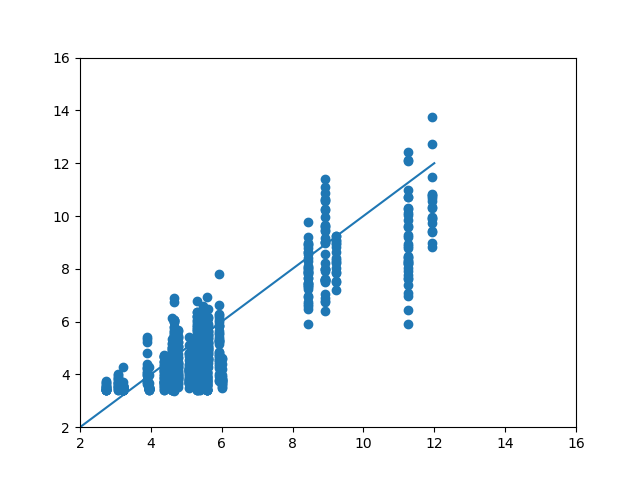

In [64]:
%matplotlib widget
plot_against(best_model, data_preparation(im_test), label_test)

In [66]:
save_path = os.path.join(storage_path, "models", "model_vendredi")
best_model.save(save_path)

2022-08-12 16:34:00.585513: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /media/kahane/AMFtopology02/storage/models/model_vendredi/assets
2022-08-12 16:34:02,605-[INFO]- tensorflow:779 -> Assets written to: /media/kahane/AMFtopology02/storage/models/model_vendredi/assets


In [38]:
best_model.evaluate(test_feature, test_label)

3/3 [==============================] - 0s 6ms/step - loss: 2.2786 - mean_absolute_error: 1.0133


[2.278571844100952, 1.0132561922073364]

In [39]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 1)]          0         
                                                                 
 rescaling (Rescaling)       (None, 120, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 111, 160)          1760      
                                                                 
 re_lu (ReLU)                (None, 111, 160)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 102, 128)          204928    
                                                                 
 re_lu_1 (ReLU)              (None, 102, 128)          0         
                                                                 
 average_pooling1d (AverageP  (None, 51, 128)          0     

In [40]:
tuner.get_best_models(5)

2022-06-07 15:53:58,773-[WARNING]- tensorflow:185 -> Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
2022-06-07 15:53:58,774-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.iter
2022-06-07 15:53:58,775-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1
2022-06-07 15:53:58,777-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2
2022-06-07 15:53:58,778-[WARNING]- tensorflow:194 -> Value in checkpoint could not be found in the restored object: (root).optimizer.decay
2022-06-07 15:53:58,779-[WARNI

### Evaluate with data augmentation

In [49]:
from amftrack.ml.width.data_augmentation import *

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(120, 1)),
        random_crop(120),
        # random_invert(p=0.5),  # TODO(FK): keep?
        random_mirror(p=0.5),
        random_brightness(20),
    ]
)

In [50]:
data_preparation

In [42]:
test_feature

Array([[199, 198, 197, ..., 203, 204, 207],
       [175, 177, 176, ..., 167, 166, 166],
       [194, 194, 194, ..., 146, 134, 120],
       ...,
       [186, 186, 186, ..., 179, 177, 179],
       [204, 206, 206, ..., 205, 206, 206],
       [188, 189, 188, ..., 174, 177, 179]], dtype=uint8)

In [44]:
test_label.shape

(74, 1)

In [45]:
test_feature_ = data_augmentation(test_feature)

TensorShape([1, 80, 1])

In [ ]:
best_model.evaluate(test_feature, test_label)

In [41]:
data_augmentation

## BROUILLON

In [276]:
e

(<tf.Tensor: shape=(32, 80, 1), dtype=float32, numpy=
 array([[[130.],
         [130.],
         [130.],
         ...,
         [127.],
         [128.],
         [129.]],
 
        [[113.],
         [111.],
         [109.],
         ...,
         [129.],
         [128.],
         [125.]],
 
        [[119.],
         [120.],
         [120.],
         ...,
         [122.],
         [123.],
         [122.]],
 
        ...,
 
        [[146.],
         [144.],
         [141.],
         ...,
         [148.],
         [147.],
         [147.]],
 
        [[110.],
         [107.],
         [106.],
         ...,
         [116.],
         [115.],
         [114.]],
 
        [[124.],
         [124.],
         [124.],
         ...,
         [124.],
         [123.],
         [123.]]], dtype=float32)>,
 <tf.Tensor: shape=(32,), dtype=float64, numpy=
 array([7.26221294, 5.93755418, 5.5774322 , 4.19787153, 3.7441611 ,
        5.20109506, 4.87914297, 0.        , 8.52101685, 8.73503977,
        4.5910988

TEST 1

In [125]:
data_augmentation(train_feature).shape

TensorShape([527, 80, 1])

TEST 2

In [186]:
data_augmentation(train_feature)[:3,:3]

<tf.Tensor: shape=(3, 3, 1), dtype=float32, numpy=
array([[[131.],
        [130.],
        [129.]],

       [[130.],
        [130.],
        [128.]],

       [[130.],
        [131.],
        [131.]]], dtype=float32)>

TEST 3

In [187]:
help(tuner.search)

Help on method search in module keras_tuner.engine.base_tuner:

search(*fit_args, **fit_kwargs) method of keras_tuner.tuners.randomsearch.RandomSearch instance
    Performs a search for best hyperparameter configuations.
    
    Args:
        *fit_args: Positional arguments that should be passed to
          `run_trial`, for example the training and validation data.
        **fit_kwargs: Keyword arguments that should be passed to
          `run_trial`, for example the training and validation data.



TEST 4: making an augmented dataset from the tensor

In [188]:
help(tf.data.Dataset)

Help on class DatasetV2 in module tensorflow.python.data.ops.dataset_ops:

class DatasetV2(collections.abc.Iterable, tensorflow.python.training.tracking.base.Trackable, tensorflow.python.framework.composite_tensor.CompositeTensor)
 |  DatasetV2(variant_tensor)
 |  
 |  Represents a potentially large set of elements.
 |  
 |  The `tf.data.Dataset` API supports writing descriptive and efficient input
 |  pipelines. `Dataset` usage follows a common pattern:
 |  
 |  1. Create a source dataset from your input data.
 |  2. Apply dataset transformations to preprocess the data.
 |  3. Iterate over the dataset and process the elements.
 |  
 |  Iteration happens in a streaming fashion, so the full dataset does not need to
 |  fit into memory.
 |  
 |  Source Datasets:
 |  
 |  The simplest way to create a dataset is to create it from a python `list`:
 |  
 |  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
 |  >>> for element in dataset:
 |  ...   print(element)
 |  tf.Tensor(1, sh

In [ ]:
  file_path_features = [data_path_from_slice_path(path) for path in file_paths]

    both_path = tf.data.Dataset.from_tensor_slices(
        [list(couple) for couple in zip(file_paths, file_path_features)]
    )
    general_dataset = both_path.interleave(single_slice_dataset, cycle_length=n_readers)
    general_dataset = general_dataset.shuffle(shuffle_buffer_size).repeat(repeat)
    return general_dataset.batch(1)  # Output shape: (1, 120, 1)
    # TODO(FK): remove the batching here and the prefetch  .prefetch(1)

In [197]:
train_feature.shape

(527, 120)

In [219]:
prov = np.expand_dims(train_feature[4,:], axis=0)

In [220]:
prov.shape

(1, 120)

In [236]:
prov = np.expand_dims(train_feature[4,:], axis=-1)
prov = np.expand_dims(prov, axis=0)
prov.shape

(1, 120, 1)

In [143]:
def random_crop(output_size):
    # TODO(FK): add name
    # TODO(FK): handle size
    size = [74, output_size, 1]
    return tf.keras.layers.Lambda(lambda x: tf.image.random_crop(x, size=size))


@tf.function
def center_crop_slice(x, margin):
    return x[..., margin:-margin, :]


def center_crop(input_size=120, output_size=80):
    return tf.keras.layers.Lambda(
        lambda x: center_crop_slice(x, (input_size - output_size) // 2)
    )


data_augmentation = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(120, 1)),
        random_crop(80),
        # random_invert(p=0.5),  # TODO(FK): keep?
        #random_mirror(p=0.5),
        #random_brightness(10),
    ]
)

In [100]:
from amftrack.ml.width.data_augmentation import *

In [79]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(120, 1)),
        random_crop(80),
    ]
)

In [132]:
test_feature

Array([[199, 198, 197, ..., 203, 204, 207],
       [175, 177, 176, ..., 167, 166, 166],
       [194, 194, 194, ..., 146, 134, 120],
       ...,
       [186, 186, 186, ..., 179, 177, 179],
       [204, 206, 206, ..., 205, 206, 206],
       [188, 189, 188, ..., 174, 177, 179]], dtype=uint8)

In [144]:
feature_vector = data_augmentation(test_feature)

In [145]:
tf.random.set_seed(12)

In [146]:
feature_vector[:, 0, 0]

<tf.Tensor: shape=(74,), dtype=float32, numpy=
array([196., 166., 188., 186., 162., 200., 198., 157., 201., 180., 194.,
       188., 184., 189., 183., 180., 165., 155., 202., 171., 171., 203.,
       186., 173., 206., 176., 161., 200., 187., 175., 177., 194., 184.,
       181., 189., 194., 197., 194., 193., 200., 165., 183., 197., 205.,
       191., 155., 167., 168., 182., 178., 185., 192., 198., 158., 196.,
       168., 199., 177., 196., 203., 164., 193., 174., 189., 178., 197.,
       178., 202., 126., 175., 146., 170., 209., 186.], dtype=float32)>

In [147]:
feature_vector[:, 0, 0]

<tf.Tensor: shape=(74,), dtype=float32, numpy=
array([196., 166., 188., 186., 162., 200., 198., 157., 201., 180., 194.,
       188., 184., 189., 183., 180., 165., 155., 202., 171., 171., 203.,
       186., 173., 206., 176., 161., 200., 187., 175., 177., 194., 184.,
       181., 189., 194., 197., 194., 193., 200., 165., 183., 197., 205.,
       191., 155., 167., 168., 182., 178., 185., 192., 198., 158., 196.,
       168., 199., 177., 196., 203., 164., 193., 174., 189., 178., 197.,
       178., 202., 126., 175., 146., 170., 209., 186.], dtype=float32)>

In [148]:
best_model.evaluate(feature_vector, test_label)

3/3 [==============================] - 0s 1ms/step - loss: 5.2993 - mean_absolute_error: 1.2498


[5.299310207366943, 1.2498197555541992]

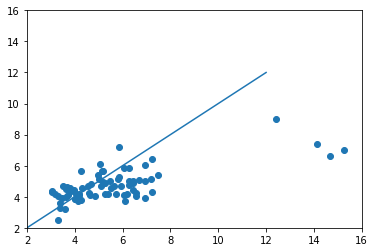

In [149]:
plot_against(best_model, feature_vector, test_label)

In [237]:
data_augmentation(prov)

<tf.Tensor: shape=(1, 80, 1), dtype=float32, numpy=
array([[[117.],
        [115.],
        [116.],
        [117.],
        [118.],
        [117.],
        [118.],
        [119.],
        [118.],
        [120.],
        [123.],
        [123.],
        [124.],
        [125.],
        [126.],
        [127.],
        [131.],
        [130.],
        [131.],
        [136.],
        [138.],
        [140.],
        [145.],
        [156.],
        [163.],
        [160.],
        [152.],
        [140.],
        [132.],
        [131.],
        [126.],
        [124.],
        [124.],
        [123.],
        [122.],
        [118.],
        [119.],
        [121.],
        [124.],
        [125.],
        [121.],
        [122.],
        [122.],
        [121.],
        [121.],
        [120.],
        [118.],
        [119.],
        [120.],
        [119.],
        [116.],
        [118.],
        [118.],
        [117.],
        [118.],
        [119.],
        [119.],
        [117.],
        [115.],
    

In [200]:
train_feature[5,:].shape

(120,)

In [205]:
type(train_label[1])

numpy.ndarray

In [207]:
type(np.array(train_feature[6,:]))

numpy.ndarray

In [209]:
len(train_feature)

527

In [210]:
both_path = tf.data.Dataset.from_tensor_slices(
        [list(couple) for couple in zip([np.array(train_feature[i,:]) for i in range(len(train_feature))], train_label)]
    )

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [232]:
train_feature.shape

(527, 120)

In [233]:
data_augmentation(train_feature).shape

TensorShape([527, 80, 1])

In [233]:
data_augmentation(train_feature).shape

TensorShape([527, 80, 1])

In [230]:
d1 = tf.data.Dataset.from_tensor_slices(train_feature)
d1_ = d1.map(lambda x: np.expand_dims(x, 0))

NotImplementedError: in user code:

    File "/tmp/ipykernel_21812/3081659417.py", line 2, in None  *
        lambda x: np.expand_dims(x, 0)
    File "<__array_function__ internals>", line 180, in expand_dims  **
        
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/numpy/lib/shape_base.py", line 591, in expand_dims
        a = asanyarray(a)

    NotImplementedError: Cannot convert a symbolic Tensor (args_0:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


In [227]:
d2 = tf.data.Dataset.from_tensor_slices(train_label)
d3 = tf.data.Dataset.zip((d1, d2))

In [225]:
train = (
    d3.map(lambda x, y: (data_augmentation(x, training=True), y))
    .unbatch()
    .batch(BATCHSIZE)
    .prefetch(tf.data.AUTOTUNE)
)

2022-08-16 18:05:48,465-[WARNING]- tensorflow:665 -> Model was constructed with shape (None, 120, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 120, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (120,).


ValueError: in user code:

    File "/tmp/ipykernel_21812/1607789451.py", line 2, in None  *
        lambda x, y: (data_augmentation(x, training=True), y)
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 80, in <lambda>
        lambda x: random_crop_slice(x, original_size, input_size, offset),

    ValueError: Exception encountered when calling layer "random_crop_with_offset_0" (type Lambda).
    
    in user code:
    
        File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 74, in random_crop_slice  *
            return x[..., start_index : start_index + input_size, :]
    
        ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT64, T=DT_FLOAT, begin_mask=4, ellipsis_mask=1, end_mask=4, new_axis_mask=0, shrink_axis_mask=0](x, strided_slice/stack, strided_slice/stack_1, strided_slice/Cast)' with input shapes: [120], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(120,), dtype=float32)
      • mask=None
      • training=True


## BROUILLON

In [66]:
train_feature.shape

(377, 120)

In [77]:
prov = np.expand_dims(train_feature, axis=-1).shape

In [79]:
help(tf.data.Dataset.from_tensor_slices)

Help on function from_tensor_slices in module tensorflow.python.data.ops.dataset_ops:

from_tensor_slices(tensors, name=None)
    Creates a `Dataset` whose elements are slices of the given tensors.
    
    The given tensors are sliced along their first dimension. This operation
    preserves the structure of the input tensors, removing the first dimension
    of each tensor and using it as the dataset dimension. All input tensors
    must have the same size in their first dimensions.
    
    >>> # Slicing a 1D tensor produces scalar tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
    >>> list(dataset.as_numpy_iterator())
    [1, 2, 3]
    
    >>> # Slicing a 2D tensor produces 1D tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
    >>> list(dataset.as_numpy_iterator())
    [array([1, 2], dtype=int32), array([3, 4], dtype=int32)]
    
    >>> # Slicing a tuple of 1D tensors produces tuple elements containing
    

In [78]:
train_ds = tf.data.Dataset.from_tensor_slices(prov)

ValueError: Unbatching a tensor is only supported for rank >= 1

In [69]:
for e in train_ds:
    print(e.shape)

(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(1, 120)
(

In [65]:
data_preparation(train_feature).shape

TensorShape([377, 80, 1])

In [62]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_feature)
train_dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(120,), dtype=tf.uint8, name=None)>

In [57]:
train = (
    train_dataset.map(lambda x: (data_augmentation(x, training=True)))
    .unbatch()
    .batch(BATCHSIZE)
    .prefetch(tf.data.AUTOTUNE)
)

2022-08-16 16:51:06,205-[WARNING]- tensorflow:665 -> Model was constructed with shape (None, 120, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 120, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (120,).


ValueError: in user code:

    File "/tmp/ipykernel_21812/1439737797.py", line 2, in None  *
        lambda x: (data_augmentation(x, training=True))
    File "/home/felix/Wks/AMFtrack/venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 80, in <lambda>
        lambda x: random_crop_slice(x, original_size, input_size, offset),

    ValueError: Exception encountered when calling layer "random_crop_with_offset_0" (type Lambda).
    
    in user code:
    
        File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 74, in random_crop_slice  *
            return x[..., start_index : start_index + input_size, :]
    
        ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT64, T=DT_FLOAT, begin_mask=4, ellipsis_mask=1, end_mask=4, new_axis_mask=0, shrink_axis_mask=0](x, strided_slice/stack, strided_slice/stack_1, strided_slice/Cast)' with input shapes: [120], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(120,), dtype=float32)
      • mask=None
      • training=True


In [55]:
train_dataset = (
        train_dataset.map(data_augmentation)
        .unbatch()
        .batch(BATCHSIZE)
        .prefetch(tf.data.AUTOTUNE)
    )

2022-08-16 16:49:36,925-[WARNING]- tensorflow:665 -> Model was constructed with shape (None, 120, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 120, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (120,).


ValueError: Exception encountered when calling layer "random_crop_with_offset_0" (type Lambda).

in user code:

    File "/home/felix/Wks/AMFtrack/amftrack/ml/width/data_augmentation.py", line 74, in random_crop_slice  *
        return x[..., start_index : start_index + input_size, :]

    ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT64, T=DT_FLOAT, begin_mask=4, ellipsis_mask=1, end_mask=4, new_axis_mask=0, shrink_axis_mask=0](x, strided_slice/stack, strided_slice/stack_1, strided_slice/Cast)' with input shapes: [120], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.


Call arguments received:
  • inputs=tf.Tensor(shape=(120,), dtype=float32)
  • mask=None
  • training=False